# Simulations with PyHEADTAIL

## Imports

In [1]:
import PyHEADTAIL

PyHEADTAIL v1.12.4




In [2]:
from PyHEADTAIL.trackers.wrapper import LongWrapper

In [3]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib tk

import matplotlib.image as mpimg

from scipy.constants import c, e, m_p

from matplotlib import animation, rc
from IPython.display import HTML

In [4]:
from PyCERNmachines.CERNmachines import PS

## Defining several parameters of the accelerator

In [5]:
Ekin = 1.4e9
gamma = 1 + Ekin * e /(m_p*c**2)
beta = np.sqrt(1-gamma**-2)

Q_x = 6.23
Q_y = 6.24

machine = PS(n_segments=1, gamma=gamma, machine_configuration = 'LHCbeam_h7',
            longitudinal_focusing = 'non-linear', Q_x=Q_x, Q_y=Q_y)

Synchrotron init. From kwargs: machine_configuration = 'LHCbeam_h7'
Synchrotron init. From kwargs: Q_y = 6.24
Synchrotron init. From kwargs: n_segments = 1
Synchrotron init. From kwargs: gamma = 2.4921045053287254
Synchrotron init. From kwargs: Q_x = 6.23


In [6]:
1/machine.Q_s

739.9159648282383

In [7]:
machine.longitudinal_map.pop_kick(1)
machine.longitudinal_map.phi_offsets[0] += np.pi

## Defining several parameters for the bunch/simulation

Defining the count of turns

In [8]:
n_turns = int((1/machine.Q_s) * 7.1)

Defining other parameters

In [9]:
n_macroparticles = 1000
intensity = 1.6e12
epsn_x = epsn_y = 2.5e-6
sigma_z = 185e-9/4*beta*c

bunch = machine.generate_6D_Gaussian_bunch_matched(
    n_macroparticles=n_macroparticles, intensity=intensity, epsn_x=epsn_x,
    epsn_y=epsn_y, sigma_z=sigma_z)

*** Maximum RMS bunch length 14.14653369562553m.


/afs/cern.ch/user/p/papostel/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


... distance to target bunch length: -1.2573e+01
... distance to target bunch length: 1.0562e+00
... distance to target bunch length: 9.8532e-01
... distance to target bunch length: -5.6875e-01
... distance to target bunch length: 4.1787e-01
... distance to target bunch length: 1.1448e-01
... distance to target bunch length: -8.8436e-03
... distance to target bunch length: 5.5485e-04
... distance to target bunch length: 2.5097e-06
... distance to target bunch length: -1.3242e-05
--> Bunch length: 12.700169357977446
--> Emittance: 1.2136287277619604


Circumference of the PS

In [10]:
machine.circumference

628.3185307179587

In [11]:
rfsystems = machine.longitudinal_map
rfbucket = rfsystems.get_bucket(bunch)

In [12]:
rfsystems._elements.append(
    LongWrapper(machine.circumference))

Defining arrays to save the values of the simulation

In [13]:
x_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)
y_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)
z_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)
dp_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)

## Simulation calculations

In [14]:
for i in range(n_turns):
    for m in machine.one_turn_map:
        x_rec[i, :] = bunch.x
        y_rec[i, :] = bunch.y
        z_rec[i, :] = bunch.z
        dp_rec [i, :] = bunch.dp
        m.track(bunch)

## Analysis of the simulation

Plotting the x- and y-positions

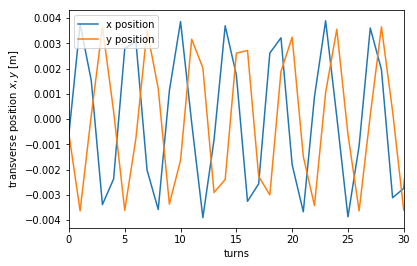

In [15]:
plt.plot(x_rec[:, 1], label='x position')
plt.plot(y_rec[:, 1], label='y position')
plt.legend(loc=2)
plt.xlim(0, 30)
plt.xlabel('turns')
plt.ylabel('transverse position $x, y$ [m]')
plt.show()

Plotting the z-position

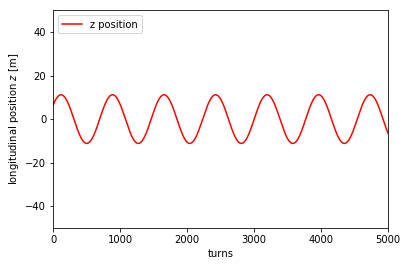

In [16]:
plt.plot(z_rec[:, 1], label='z position', color='red')
plt.legend(loc=2)
plt.xlim(0, 5000)
plt.ylim(-50, 50)
plt.xlabel('turns')
plt.ylabel('longitudinal position $z$ [m]')
plt.show()

Plotting the momentum deviation $\delta$ for one of the other particles

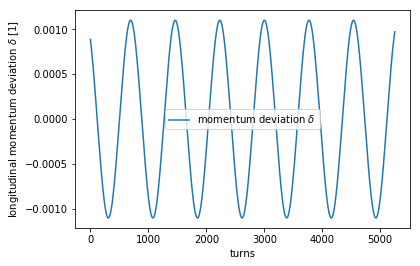

In [17]:
plt.plot(dp_rec[:, 1], label='momentum deviation $\delta$')
plt.legend()
# plt.xlim(0, 30)
plt.xlabel('turns')
plt.ylabel('longitudinal momentum deviation $\delta$ [1]')
plt.show()

## Longitudinal Motion:

### A simple video first

Animating a video of the bucket, in which all stable particles are.

In [18]:
!mkdir Video_Longitudinal_Motion_One_Bucket

mkdir: cannot create directory `Video_Longitudinal_Motion_One_Bucket': File exists


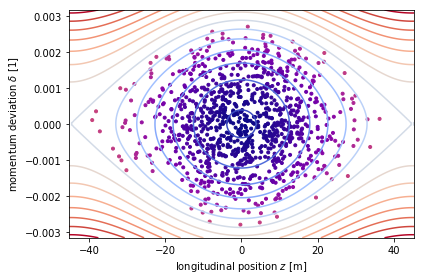

In [19]:
!rm Video_Longitudinal_Motion_One_Bucket/*

zz = np.linspace(*rfbucket.interval, num=1000)
dp_max = rfbucket.separatrix(0)
dpp = np.linspace(-dp_max*1.1, dp_max*1.1, num=100)
ZZ, DPP = np.meshgrid(zz, dpp)
HH = rfbucket.hamiltonian(ZZ, DPP)

def animate (i):
    plt.cla()
    z = z_rec[i, :]
    dp = dp_rec[i, :]
    
    # Markers are green!!
    #plt.scatter(z, dp, marker='.', color='green')
    
    # Or the markers are colored!!
    plt.scatter(z, dp, marker='.', c=rfbucket.hamiltonian(z, dp), 
                cmap=plt.get_cmap('plasma'), vmax=np.max(np.abs(rfbucket.hamiltonian(z, dp))) * 1)
    
    plt.contour(ZZ, DPP, HH, 15, cmap=plt.get_cmap('coolwarm'))
    
    plt.xlim(rfbucket.interval)
    plt.ylim(-dp_max * 1.1, dp_max * 1.1)
    
    plt.xlabel('longitudinal position $z$ [m]')
    plt.ylabel('momentum deviation $\delta$ [1]')
    
    plt.tight_layout()
    
    x = z_rec[i, :]
    y = dp_rec[i, :]
    
    plt.savefig("Video_Longitudinal_Motion_One_Bucket/src{:05d}.png".format(i), dpi=200, bbox_inches='tight')

for i in range(0, len(z_rec), 10):
    animate(i)

In [20]:
!cd Video_Longitudinal_Motion_One_Bucket; ffmpeg -y -pattern_type glob -i "*.png" -c:v msmpeg4v2 -q:v 1 -pix_fmt yuv420p one_bucket.wmv

ffmpeg version N-90661-g52623bc Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.4.7 (GCC) 20120313 (Red Hat 4.4.7-18)
  configuration: --prefix=/afs/cern.ch/user/p/papostel/lib/
  libavutil      56. 13.100 / 56. 13.100
  libavcodec     58. 17.100 / 58. 17.100
  libavformat    58. 11.101 / 58. 11.101
  libavdevice    58.  2.100 / 58.  2.100
  libavfilter     7. 14.100 /  7. 14.100
  libswscale      5.  0.102 /  5.  0.102
  libswresample   3.  0.101 /  3.  0.101
Input #0, image2, from '*.png':
  Duration: 00:00:21.04, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1166x767 [SAR 7874:7874 DAR 1166:767], 25 fps, 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> msmpeg4v2 (native))
Press [q] to stop, [?] for help
Output #0, asf, to 'one_bucket.wmv':
  Metadata:
    WM/EncodingSettings: Lavf58.11.101
    Stream #0:0: Video: msmpeg4v2 (MP42 / 0x3234504D), yuv420p, 1166x767 [SAR 1:1 DAR 1166:767], q=2-31, 200 kb/s, 25 fps, 1k t

    Last message repeated 736 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 183 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 74 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 283 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 577 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 244 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 145 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 15 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 347 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 774 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 362 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 188 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 12 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 342 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 176 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 17 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message rep

    Last message repeated 1526 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 379 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 187 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 171 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 19 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 

    Last message repeated 1177 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 683 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 221 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 308 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 178 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 193 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 73 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 88 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 167 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 347 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 30 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 151 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 804 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 185 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 22 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 10 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 135 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 74 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 90 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 203 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 343 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 245 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 139 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 29 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 123 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 995 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 400 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 187 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 14 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 14 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 15 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 142 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x

    Last message repeated 153 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 674 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 754 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 13 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 80 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 69 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 19 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 151 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 30 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 183 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct c

    Last message repeated 719 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 77 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 116 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 53 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 125 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 75 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 109 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 11 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 70 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct c

    Last message repeated 623 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 184 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 95 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 166 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 285 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 11 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 189 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 73 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 668 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 54 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 186 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 737 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 321 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 26 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 478 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 612 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 13 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 1702 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 15 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 176 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 36 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 1080 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 876 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 118 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 201 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 21 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 51 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 321 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2

    Last message repeated 34 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 175 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 40 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @

    Last message repeated 174 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 13 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 138 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 395 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 153 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 779 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 30 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coeff

[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 13 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 46 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 161 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 20 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 146 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last 

    Last message repeated 209 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 369 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 10 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last me

    Last message repeated 162 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 207 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coef

    Last message repeated 772 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 12 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 176 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 178 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 349 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 62 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 880 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 32 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 165 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 772 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 22 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 18 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 168 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct co

    Last message repeated 220 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 187 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 179 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct co

    Last message repeated 137 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 180 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 174 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 196 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dc

    Last message repeated 966 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 182 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 365 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 237 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 536 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 15 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 280 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 874 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 194 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 58 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 51 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 480 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 955 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 13 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 110 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 852 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 201 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 222 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 177 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 177 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 365 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 21 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 194 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 12 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 262 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 133 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 49 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 148 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 152 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 637 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 179 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 35 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 186 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 185 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 381 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 176 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 187 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 215 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 178 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 12 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 276 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 698 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 80 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 104 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 23 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 221 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 13 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 105 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct 

    Last message repeated 58 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 117 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 20 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 39 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 131 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 13 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct 

    Last message repeated 133 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 28 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 28 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 172 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 142 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 217 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 36 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 22 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 114 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct co

    Last message repeated 1000 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 186 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 16 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 168 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 10 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 174 times
[msmpeg4v2 @ 0

    Last message repeated 319 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 233 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 301 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 66 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 51 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 155 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 774 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 81 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 283 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 25 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 48 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 134 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 66 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 178 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct

    Last message repeated 146 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 168 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 169 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 20 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 151 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 164 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 18 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 165 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 12 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 22 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @

    Last message repeated 1128 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 133 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 188 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 183 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 174 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 176 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 151 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 118 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 277 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 780 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 192 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 462 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 201 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 469 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 206 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 146 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 55 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 914 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 150 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 185 times
[msmpeg4v2 @ 0x2

    Last message repeated 163 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 171 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 172 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 193 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 155 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 268 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 1480 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 41 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 146 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 402 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 335 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 223 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 172 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message rep

    Last message repeated 1936 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 346 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 579 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 797 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 182 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 532 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 45 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 11 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 328 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 197 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 189 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 13 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 

    Last message repeated 975 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 10 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 61 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 13 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 76 times
[msmpeg4v2 @ 0x2

    Last message repeated 153 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 177 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 202 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 40 times
[msmpeg4v2 @ 0x

    Last message repeated 152 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 197 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 185 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 22 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 41 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 139 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 977 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 570 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 38 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 148 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 11 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 13 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct c

    Last message repeated 196 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 74 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 124 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 179 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct c

    Last message repeated 788 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 210 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 45 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 140 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 178 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 16 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 161 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 16 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 154 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 726 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 19 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 67 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 57 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 826 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 190 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 189 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 41 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 140 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 353 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 54 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 320 times


[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 195 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 35 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 322 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 15 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 1313 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 372 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 355 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 214 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 63 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 137 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 1170 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 404 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 181 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 188 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 175 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 194 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 211 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 183 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 12 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct c

    Last message repeated 206 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 1666 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 212 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 291 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 20 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 11 times
[msmpeg4v2 @ 0x2

    Last message repeated 232 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 319 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 745 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 368 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 194 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 199 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 221 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 181 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 186 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 78 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 295 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 33 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 41 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 92 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 14 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct co

    Last message repeated 768 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 173 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 51 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 515 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 184 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 130 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 804 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 1003 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 163 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 185 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 179 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 189 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 213 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 353 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 226 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 1127 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 197 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 691 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 224 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 541 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 992 times


[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 202 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 121 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 294 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 406 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 139 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 46 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 177 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 41 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 145 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 183 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 791 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 186 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 180 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message rep

    Last message repeated 783 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 157 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 185 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 192 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 16 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 23 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 186 times
[msmpeg4v2 @ 0

    Last message repeated 752 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 11 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 14 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 397 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 17 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 183 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 192 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 17 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 39 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 187 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 124 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct 

    Last message repeated 358 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 194 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 177 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 818 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 182 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127


    Last message repeated 302 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 69 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 112 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 52 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 17 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 173 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct

    Last message repeated 303 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 10 times
[msmpeg4v2 @ 0x29e8700] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x29e8700] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 453 times
frame=  526 fps= 45 q=1.0 Lsize=   96735kB time=00:00:21.00 bitrate=37734.1kbits/s speed=1.79x    
video:95937kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.831720%


See also the orginial code:

https://github.com/PyCOMPLETE/PyHEADTAIL-playground/blob/master/index.ipynb

## The End